In [10]:
# Use python 3
from configparser import ConfigParser, ExtendedInterpolation

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from spikelib import spiketools as spkt 
from spikelib.utils import check_directory
from spikelib import visualizations as vis

from chirp import get_chirp_subevents

%matplotlib notebook

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../../Ensembles/MR-0227/config.ini')

['../../../Ensembles/MR-0227/config.ini']

In [23]:
exp_name = config['EXP']['name']
sorting_file = config['FILES']['sorting']
sync_file = config['SYNC']['events']
start_end_path = config['SYNC']['frametime']
repeated_path = config['SYNC']['repeated']
sub_sync_file = config['SYNC']['folder'] + f'sub_event_list_{exp_name:s}.csv'

In [24]:
# Read protocols time directly from fevent file
df = pd.read_csv(sync_file)
protocol_name = 'flash'
nd_filter = 'nd4'
intensities = [50, 100, 150, 200, 255]
intensity = intensities[-2]
extra_info = 'cyan'

# General parameters
samplerate = 20000.0

# Temporal resolution of flash response
psth_bin = 0.01  # In sec
bandwidth_fit = psth_bin
fit_resolution = 0.001  # In sec

In [25]:
names = ['ON', 'OFF', 'adap_0', 'FREQ', 'adap_1', 'AMP', 'adap_2']
times = [3, 3, 2, 15, 2, 8, 2]

events = get_chirp_subevents(sync_file, start_end_path, repeated_path, sub_sync_file, names, times)

In [26]:
events

,n_frames,start_event,end_event,start_next_event,event_duration,event_duration_seg,inter_event_duration,inter_event_duration_seg,protocol_name,extra_description,protocol_spec,rep_name,repetead_frames,#repetead_frames
0,180,12437222,12497470,12497470,60248,3.01240,0,0.0,chirp,ON,NaN,rep_000,,0
1,180,12497470,12557718,12557718,60248,3.01240,0,0.0,chirp,OFF,NaN,rep_000,,0
2,120,12557718,12597884,12597884,40166,2.00830,0,0.0,chirp,adap_0,NaN,rep_000,,0
3,900,12597884,12899124,12899124,301240,15.06200,0,0.0,chirp,FREQ,NaN,rep_000,,0
4,120,12899124,12939289,12939289,40165,2.00825,0,0.0,chirp,adap_1,NaN,rep_000,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,120,28216512,28256677,28256677,40165,2.00825,0,0.0,chirp,adap_0,NaN,rep_020,,0
3,900,28256677,28557917,28557917,301240,15.06200,0,0.0,chirp,FREQ,NaN,rep_020,,0
4,120,28557917,28598082,28598082,40165,2.00825,0,0.0,chirp,adap_1,NaN,rep_020,,0
5,480,28598082,28758744,28758744,160662,8.03310,0,0.0,chirp,AMP,NaN,rep_020,,0


# General parameters

In [38]:
# Get time from DataFrame for a especific nd_filter and intensity

fields_df = ['start_event', 'end_event', 'start_next_event']

mask_on = events['extra_description'] == 'ON'
mask_off = events['extra_description'] == 'OFF'

times_on = np.array(events[mask_on][fields_df]) / samplerate
times_off = np.array(events[mask_off][fields_df]) / samplerate

bound_time = np.array([times_on[:, 0], times_off[:, 1]]).transpose()

# Stimulius time
on_dur = np.median(np.diff(times_on[:, :-1], axis=1))
off_dur = np.median(np.diff(times_off[:, :-1], axis=1)) # Seconds
offset_time = 0
start_on = offset_time
end_on = offset_time + on_dur
start_off = offset_time + on_dur
end_off = offset_time + off_dur + on_dur
bounds = (start_on, end_on, start_off, end_off)
total_dur = off_dur + on_dur
(start_trials, end_trials) = bound_time.T
ntrails = len(start_trials)

bins_fit = np.linspace(start_on, end_off, int(np.ceil(total_dur/fit_resolution)),)
bins_psth = np.linspace(start_on, end_off, int(np.ceil(total_dur/psth_bin)))

In [41]:
# Threshold to select valid unit based on number of trials
resp_thr = 1.0/3 

# Threshold to classify into on, off, onoff
bias_thr = 0.65  

# Threshold for Response Index (RI)
ri_thr = 0.3  
ri_span = 0.1  # Windows time to compute RI in sec


# Paramiters to find the peak response and decay time
fpeak_thr = 0.5  # % of peak response 
fpeak_min_time = 0.01  # min time between peaks in sec
fpeak_min_dist_fit = int(fpeak_min_time/fit_resolution)  # Samples
decrease_factor = np.e 

# Parameters for Sustained Index (SI)
sust_span = 0.4  # Windows time to compute SI in seg

#keywords for spkt.get_features_flash()
kwargs_fit = {'resp_thr': resp_thr,
              'bias_thr': bias_thr,
              'ri_thr': ri_thr,
              'fpeak_thr': fpeak_thr,
              'fpeak_min_dist': fpeak_min_dist_fit,
              'ri_span': ri_span,
              'sust_time': sust_span,
              'decrease_factor': decrease_factor,
             } 

# Load spike times for a unit

In [42]:
key = 'temp_100'
with h5py.File(sorting_file, 'r') as spks:  
    spikes = spks['/spiketimes/'+key][...].flatten()/samplerate
trials_flash = spkt.get_trials(spikes, start_trials, end_trials,
                               offset=offset_time)
spks_flash = spkt.flatten_trials(trials_flash)

## plot psth and raster

<IPython.core.display.Javascript object>


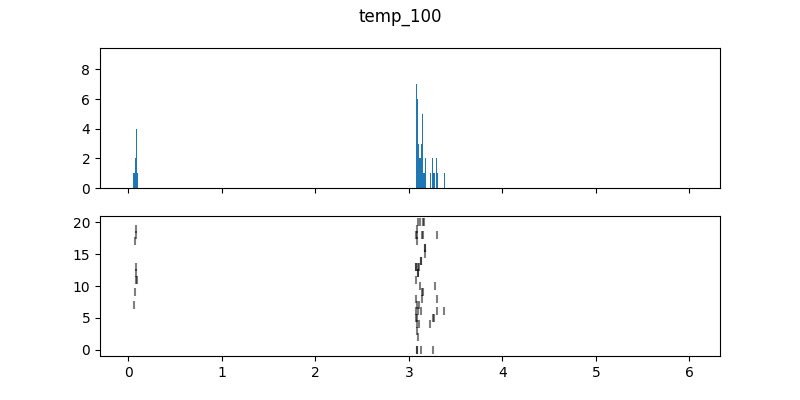

(<Figure size 800x400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f629e4a16d0>)

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
fig.suptitle(key)
vis.psth(spks_flash,ax1, bins=int((end_off-start_on)*100), range=(start_on, end_off))
vis.raster(trials_flash,ax2)

# Get flash features
## Using only PSTH to get characteristics of flash response

In [44]:
# Response
(psth, _) = np.histogram(spks_flash, bins=bins_psth)
psth = psth/float(ntrails)

kws_psth = kwargs_fit.copy()
kws_psth['fpeak_min_dist'] = 2

type_psth, char_psth = spkt.get_features_flash(psth, bins_psth[1:], bounds, **kws_psth)

print('Result using PSTH with bin={}'.format(psth_bin))
print('Flash type = {}\nParameters = {}\n'.format(type_psth, char_psth))


Result using PSTH with bin=0.01
Flash type = 2
Parameters = [ 0.          0.08006379 -1.          0.          0.02001595  0.
  0.78640777  0.          0.75609756  0.          0.42857143]



## Using only fit_response to get characteristics of flash response

In [45]:
# Response
(psth, _) = np.histogram(spks_flash, bins=bins_psth)
psth = psth/float(ntrails)
est_resp = spkt.est_pdf(trials_flash, bins_fit, bandwidth=bandwidth_fit,
                         norm_factor=psth.max())

type_fit, char_fit = spkt.get_features_flash(est_resp, bins_fit, bounds, **kwargs_fit)

print('Result using PDF with bin={}'.format(psth_bin))
print('Flash type = {}\nParameters = {}\n'.format(type_fit, char_fit))

Result using PDF with bin=0.01
Flash type = 2
Parameters = [ 0.          0.07801036 -1.          0.          0.01400186  0.
  0.78605725  0.          0.76481164  0.          0.42857143]



## Plot features from psth and est_psth

In [46]:
def plot_flash(type_fit, char_fit):
    ccolor = {0: 'k', 1: 'r', 2: 'b', 3: 'g'}

    latency_on = char_fit[0]
    latency_off = char_fit[1]
    dacay_on = char_fit[3]
    decay_off = char_fit[4]
    start_on, end_on, start_off, end_off = bounds
    max_amp = est_resp.max()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    fig.suptitle(key)
    ax1.plot(bins_fit, est_resp, c=ccolor[type_fit])
    ax1.step(bins_psth[1:], psth)
    ax1.vlines(start_on+latency_on, 0, max_amp, alpha=0.5)
    ax1.vlines(start_on+latency_on+dacay_on, 0, max_amp, alpha=0.5)
    ax1.vlines(start_off+latency_off, 0, max_amp, alpha=0.5)
    ax1.vlines(start_off+latency_off+decay_off, 0, max_amp, alpha=0.5)
    ax1.set_xlim([start_on, end_off])

    nrep = len(trials_flash)
    for krep, ktrial in enumerate(trials_flash):
        ax2.scatter(ktrial, krep*np.ones_like(ktrial),
                    marker='|', c='k', alpha=0.5)
    ax2.vlines(start_on+latency_on, 0, nrep, alpha=0.5, color='r')
    ax2.vlines(start_on+latency_on+dacay_on, 0, nrep, alpha=0.5, color='r')
    ax2.vlines(start_off+latency_off, 0, nrep, alpha=0.5, color='r')
    ax2.vlines(start_off+latency_off+decay_off, 0, nrep, alpha=0.5, color='r')
    ax2.set_xlim([start_on, end_off])
    plt.show()

<IPython.core.display.Javascript object>


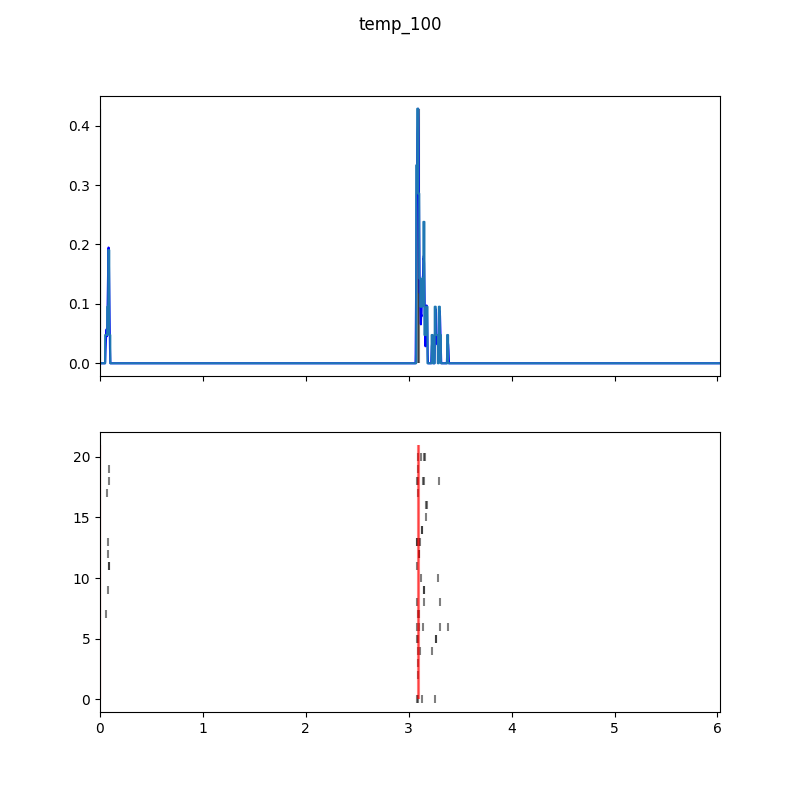

In [47]:
plot_flash(type_fit, char_fit)